<a href="https://colab.research.google.com/github/anargh-t/Graph-RAG/blob/main/Knowledge_Graph_using_LangChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install langchain-experimental langchain-community langchain networkx langchain-google-genai langchain-core json-repair
!pip install google-generativeai

  Using cached google_ai_generativelanguage-0.6.18-py3-none-any.whl.metadata (9.8 kB)
Using cached google_ai_generativelanguage-0.6.18-py3-none-any.whl (1.4 MB)
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


  Using cached google_ai_generativelanguage-0.6.15-py3-none-any.whl.metadata (5.7 kB)
Using cached google_ai_generativelanguage-0.6.15-py3-none-any.whl (1.3 MB)
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.18
    Uninstalling google-ai-generativelanguage-0.6.18:
      Successfully uninstalled google-ai-generativelanguage-0.6.18
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-google-genai 2.1.9 requires google-ai-generativelanguage<0.7.0,>=0.6.18, but you have google-ai-generativelanguage 0.6.15 which is incompatible.


In [19]:
import os
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_google_genai import GoogleGenerativeAI
import time
import networkx as nx
from langchain.chains import GraphQAChain
from langchain_core.documents import Document
from langchain_community.graphs.networkx_graph import NetworkxEntityGraph
import google.generativeai as genai

In [30]:
GOOGLE_API_KEY = 'api_key'
genai.configure(api_key=GOOGLE_API_KEY)

llm = GoogleGenerativeAI(model="gemini-2.5-flash", google_api_key=GOOGLE_API_KEY)

text = """
Marie Curie, born in 1867, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity. She was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields. Her husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes. She was, in 1906, the first woman to become a professor at the University of Paris
"""



In [21]:
documents = [Document(page_content=text)]
llm_transformer = LLMGraphTransformer(llm=llm)

In [22]:
llm_transformer_filtered = LLMGraphTransformer(
    llm=llm,

)

graph_documents_filtered = llm_transformer_filtered.convert_to_graph_documents(
    documents
)


In [23]:
# llm_transformer_filtered = LLMGraphTransformer(
#     llm=llm,
#     allowed_nodes = ["Person", "Country"],
#     allowed_relationships = ["NATIONALITY", "LOCATED_IN","WORKED_AT","SPOUSE","MOTHER"],
# )

# graph_documents_filtered = llm_transformer_filtered.convert_to_graph_documents(
#     documents
# )


In [24]:
graph = NetworkxEntityGraph()

#Add nodes to the graph
for node in graph_documents_filtered[0].nodes:
    graph.add_node(node.id)

#Add edges to the graph
for edge in graph_documents_filtered[0].relationships:
    graph._graph.add_edge(
        edge.source.id,
        edge.target.id,
        relation=edge.type,
    )

In [25]:
graph_rag = GraphQAChain.from_llm(
    llm = llm,
    graph = graph,
    verbose = True
)

In [26]:
import pandas as pd

In [27]:
df = pd.DataFrame(columns=['node1','node2','relation'])

for edge in graph_documents_filtered[0].relationships:
    df = pd.concat([df,pd.DataFrame({'node1':[edge.source.id], 'node2':[edge.target.id], 'relation':[edge.type]})], ignore_index=True)
df

,node1,node2,relation
0,Marie Curie,1867,BORN_IN
1,Marie Curie,Polish,HAS_NATIONALITY
2,Marie Curie,naturalised-French,HAS_NATIONALITY
3,Marie Curie,physicist,HAS_OCCUPATION
4,Marie Curie,chemist,HAS_OCCUPATION
5,Marie Curie,radioactivity,CONDUCTED_RESEARCH_ON
6,Marie Curie,Nobel Prize,HAS_AWARD
7,Marie Curie,first woman to win a Nobel Prize,HAS_ACHIEVEMENT
8,Marie Curie,first person to win a Nobel Prize twice,HAS_ACHIEVEMENT
9,Marie Curie,only person to win a Nobel Prize in two scient...,HAS_ACHIEVEMENT


{('Marie Curie',
  '1867'): Text(0.3522323973669592, 0.1933325709704633, 'BORN_IN'),
 ('Marie Curie',
  'Polish'): Text(0.2331741832800105, -0.39862100035284653, 'HAS_NATIONALITY'),
 ('Marie Curie',
  'naturalised-French'): Text(0.4003875535048871, -0.09283140844113746, 'HAS_NATIONALITY'),
 ('Marie Curie',
  'physicist'): Text(-0.4736071862503437, -0.2828696271560288, 'HAS_OCCUPATION'),
 ('Marie Curie',
  'chemist'): Text(-0.3407905763521014, 0.3168596939376208, 'HAS_OCCUPATION'),
 ('Marie Curie',
  'radioactivity'): Text(0.36087368118986274, 0.04753181029025244, 'CONDUCTED_RESEARCH_ON'),
 ('Marie Curie',
  'Nobel Prize'): Text(0.08486084005660155, -0.408820766171212, 'HAS_AWARD'),
 ('Marie Curie',
  'first woman to win a Nobel Prize'): Text(-0.51870389871534, -0.06449240352118868, 'HAS_ACHIEVEMENT'),
 ('Marie Curie',
  'first person to win a Nobel Prize twice'): Text(0.2744800185006331, 0.33905338981152655, 'HAS_ACHIEVEMENT'),
 ('Marie Curie',
  'only person to win a Nobel Prize in tw

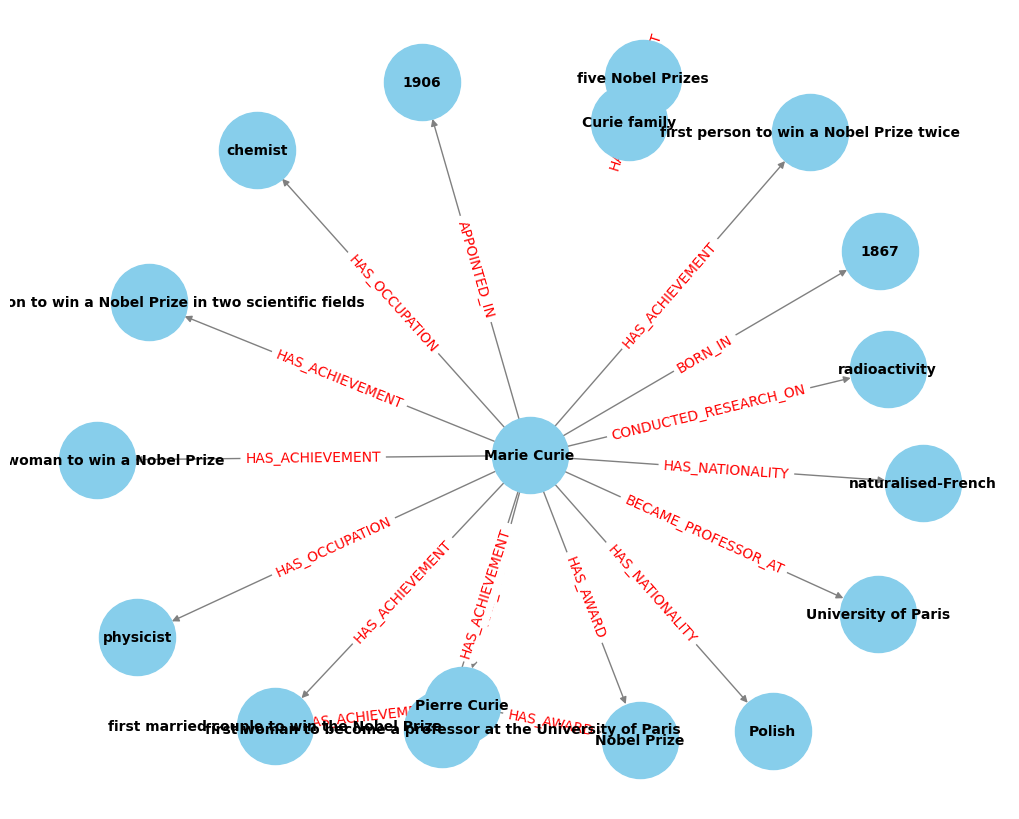

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for index, row in df.iterrows():
    G.add_edge(row['node1'], row['node2'], relationship=row['relation'])

# Draw the graph
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'relationship')

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3000, edge_color='gray', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

In [28]:
question = """who is Marie Curie"""
graph_rag.run(question)

/tmp/ipython-input-685557142.py:2: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  graph_rag.run(question)




> Entering new GraphQAChain chain...
Entities Extracted:
Marie Curie
Full Context:
Marie Curie BORN_IN 1867
Marie Curie HAS_NATIONALITY Polish
Marie Curie HAS_NATIONALITY naturalised-French
Marie Curie HAS_OCCUPATION physicist
Marie Curie HAS_OCCUPATION chemist
Marie Curie CONDUCTED_RESEARCH_ON radioactivity
Marie Curie HAS_AWARD Nobel Prize
Marie Curie HAS_ACHIEVEMENT first woman to win a Nobel Prize
Marie Curie HAS_ACHIEVEMENT first person to win a Nobel Prize twice
Marie Curie HAS_ACHIEVEMENT only person to win a Nobel Prize in two scientific fields
Marie Curie HAS_SPOUSE Pierre Curie
Marie Curie HAS_ACHIEVEMENT first married couple to win the Nobel Prize
Marie Curie BECAME_PROFESSOR_AT University of Paris
Marie Curie APPOINTED_IN 1906
Marie Curie HAS_ACHIEVEMENT first woman to become a professor at the University of Paris

> Finished chain.


'Marie Curie was a Polish and naturalised-French physicist and chemist, born in 1867. She conducted research on radioactivity and was awarded the Nobel Prize. She holds several achievements, including being the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields. She was married to Pierre Curie, and together they were the first married couple to win the Nobel Prize. In 1906, she became the first woman to become a professor at the University of Paris.'